<a href="https://colab.research.google.com/github/raz0208/Agritech-Pest-Prediction/blob/main/Agritech_Pest_Prediction_SARIMA_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis For Agritech Pest Prediction

### **SARIMA** Model Implementation:

In [46]:
# # Uninstall potentially conflicting versions first
# !pip uninstall -y pmdarima numpy

# # Install the latest NumPy 1.x version (e.g., 1.26.4)
# !pip install numpy==1.26.4

# # Now install pmdarima (hopefully it links against NumPy 1.26.4)
# # Use --no-cache-dir just to be safe
# !pip install --no-cache-dir pmdarima==2.0.4

In [47]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [48]:
# Load datasets
Merged_Dataset_df = pd.read_csv('/content/Final_Merged_Dataset_Cleaned.csv')

In [49]:
# Display basic info for  datasets Final_Merged_Dataset_Cleaned
print(Merged_Dataset_df.head(), '\n')
print(Merged_Dataset_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
0                13.91      13.6       14.4             97.65         22.34   
1                20.78      20.1       21.2             83.49         23.52   
2                19.03      18.7       19.5             96.87         25.67   
3                15.33      15.0       15.7             82.29         25.87   
4                15.48      15.0       16.0             87.12         26.41   

   Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_change  

In [50]:
# Convert 'Date' column to datetime format
Merged_Dataset_df['Date'] = pd.to_datetime(Merged_Dataset_df['Date'])

# Set Date column as index
Merged_Dataset_df.set_index('Date', inplace=True)

In [51]:
# Drop redundant columns for time series modeling
DateAgg_df = Merged_Dataset_df[['Number of Insects']].copy()

# Resample data by date (sum over locations for the same day)
DateAgg_df = DateAgg_df.resample('D').sum()

# Show the processed daily data
print(DateAgg_df.head(10))

            Number of Insects
Date                         
2024-07-05                0.0
2024-07-06                0.0
2024-07-07                0.0
2024-07-08                0.0
2024-07-09                0.0
2024-07-10                0.0
2024-07-11                0.0
2024-07-12                0.0
2024-07-13                0.0
2024-07-14                1.0


### Visualization trends

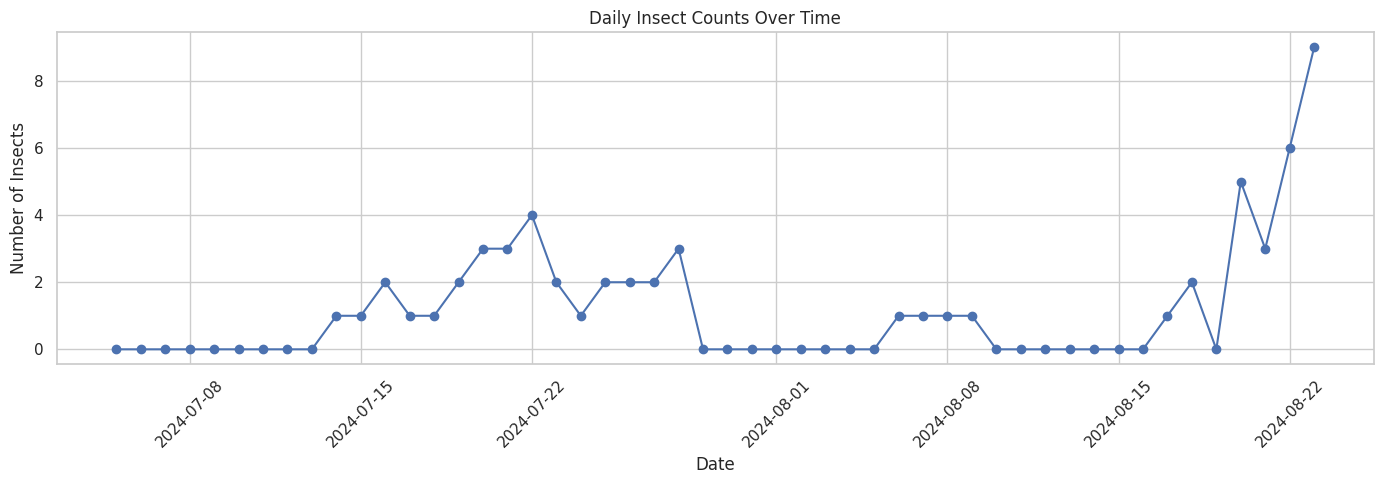

In [52]:
##-- ### Visualization trends ### --##

# Set plot style
sns.set(style="whitegrid")

# Plot the time series
plt.figure(figsize=(14, 5))
plt.plot(DateAgg_df.index, DateAgg_df['Number of Insects'], marker='o', linestyle='-')
plt.title('Daily Insect Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

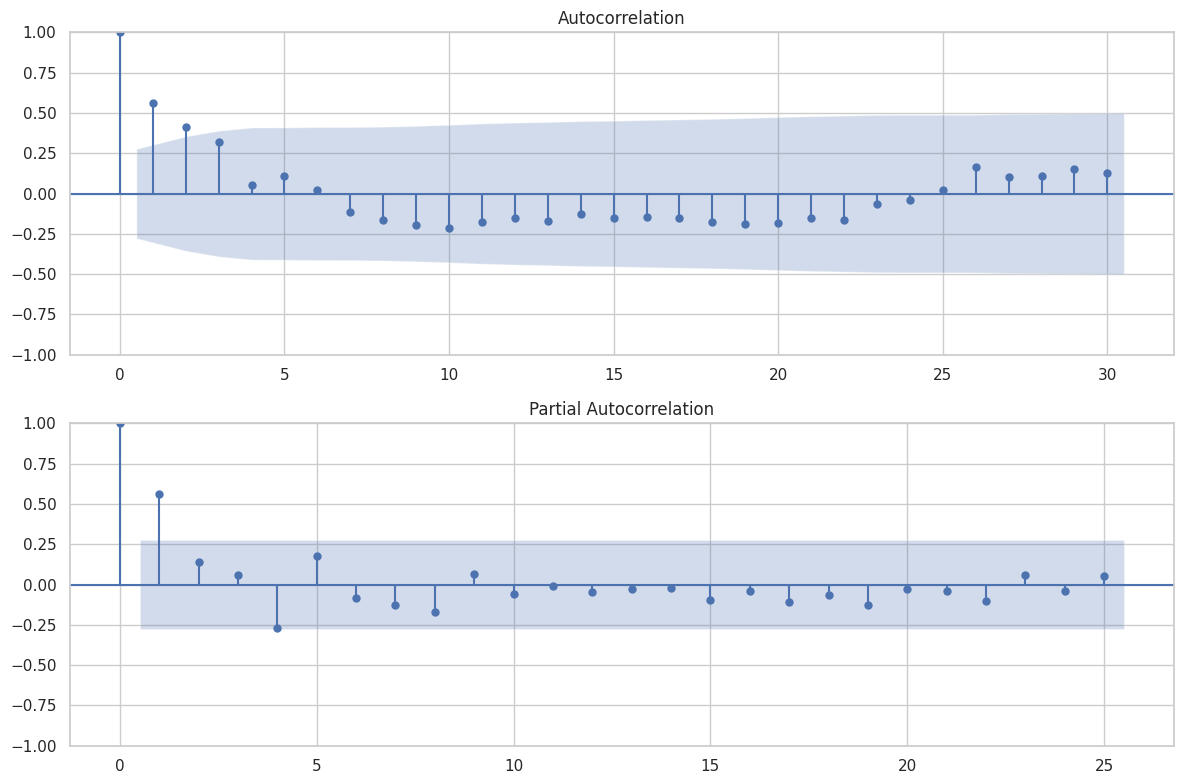

In [53]:
# Plot ACF and PACF to examine autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(DateAgg_df['Number of Insects'], lags=30, ax=ax[0])
plot_pacf(DateAgg_df['Number of Insects'], lags=25, ax=ax[1])
plt.tight_layout()
plt.show()

### Check for Stationarity (ADF Test)

ADF Statistic: -1.7530607202128317
p-value: 0.4040019312158851
# Lags Used: 7
# Observations: 42
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895
⚠️ Series is not stationary (p >= 0.05) 



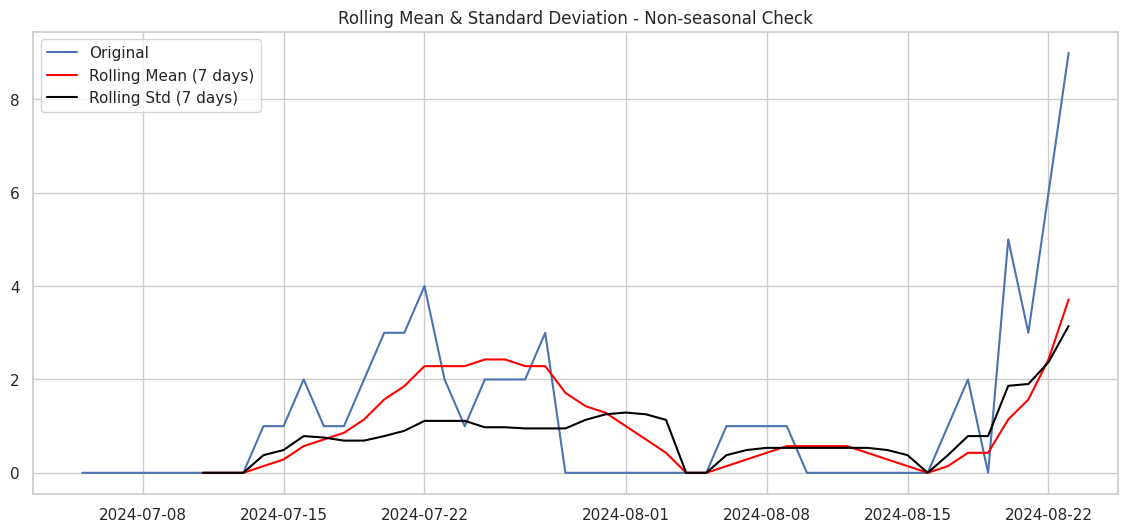

In [59]:
# Perform Augmented Dickey-Fuller (ADF) test to check for stationarity
def check_stationarity(series):
    adf_result = adfuller(series.dropna())

    result = {
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "# Lags Used": adf_result[2],
        "# Observations": adf_result[3],
        "Critical Values": adf_result[4]
    }

    # Interpretation
    result["Stationary"] = adf_result[1] < 0.05

    print("ADF Statistic:", result["ADF Statistic"])
    print("p-value:", result["p-value"])
    print("# Lags Used:", result["# Lags Used"])
    print("# Observations:", result["# Observations"])
    print("Critical Values:")
    for key, value in result["Critical Values"].items():
        print(f"   {key}: {value}")

    if result["Stationary"]:
        print("✅ Series is stationary (p < 0.05)")
    else:
        print("⚠️ Series is not stationary (p >= 0.05)", "\n")

    # Plot rolling mean and std
    rolling_mean = series.rolling(window=7).mean()
    rolling_std = series.rolling(window=7).std()

    plt.figure(figsize=(14,6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean (7 days)', color='red')
    plt.plot(rolling_std, label='Rolling Std (7 days)', color='black')
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation - Non-seasonal Check")
    plt.show()

    #return result

check_stationarity(DateAgg_df['Number of Insects'])

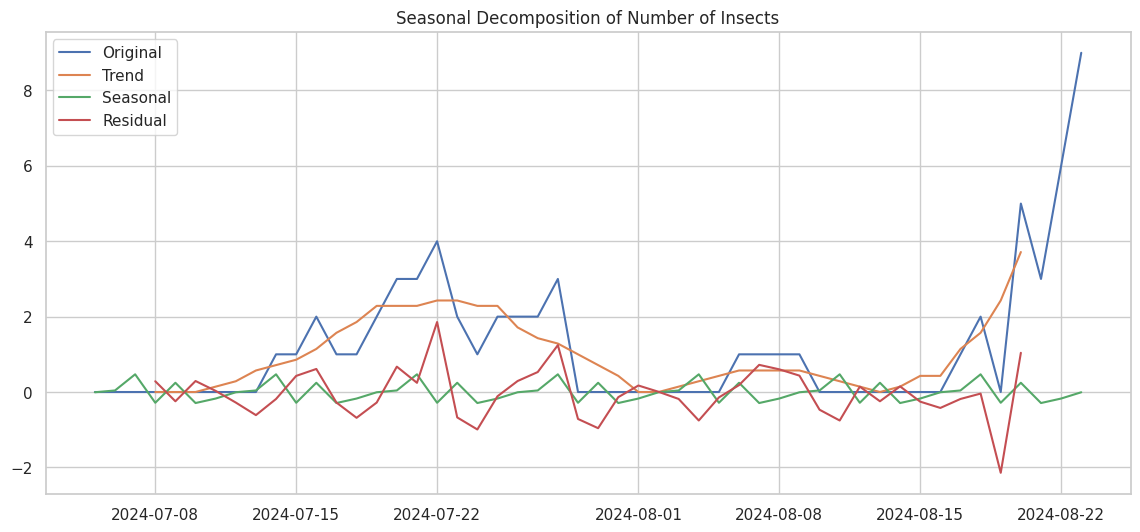

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

insects_series = DateAgg_df['Number of Insects']

# Seasonal decomposition
decomposition = seasonal_decompose(insects_series, model='additive', period=7)  # Weekly seasonality

# Visualize seasonal decomposition
plt.figure(figsize=(14,6))
plt.plot(insects_series, label='Original')
plt.plot(decomposition.trend, label='Trend')
plt.plot(decomposition.seasonal, label='Seasonal')
plt.plot(decomposition.resid, label='Residual')
plt.legend()
plt.title("Seasonal Decomposition of Number of Insects")
plt.show()
# decomposition.plot()
# plt.suptitle("Seasonal Decomposition of Number of Insects", fontsize=16)
# plt.tight_layout()
# plt.show()

### Apply Differencing (if needed) and check Stationarity

In [56]:
# ##--- ### Method 2 to make stationary ### ---##

# # Function to apply Differencing and check Stationarity
# def make_stationary(ts, max_diff=6, verbose=True):
#     d = 0
#     result = adfuller(ts.dropna())
#     if verbose:
#         print(f"ADF Test p-value (d={d}): {result[1]:.4f}")
#     while result[1] > 0.05 and d < max_diff:
#         ts = ts.diff().dropna()
#         d += 1
#         result = adfuller(ts)
#         if verbose:
#             print(f"ADF Test p-value (d={d}): {result[1]:.4f}")
#     if verbose and result[1] <= 0.05:
#         print(f"✅ Series is stationary at d={d}")
#     return ts, d

# # Call the function
# df_diff, num_diffs = make_stationary(DateAgg_df['Number of Insects'])

In [57]:
# # Plot differenced data
# plt.figure(figsize=(14, 5))
# plt.plot(df_diff, marker='o', linestyle='-')
# plt.title(f'Differenced Insect Count (Differencing {num_diffs})')
# plt.xlabel('Date')
# plt.ylabel('Differenced Value')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

### Train/Test Split

### SARIMA model configuration

In [58]:
# # # Implement SARIMA model with autoarima
# model = auto_arima(
#     DateAgg_df['Number of Insects'],
#     seasonal=True,
#     d=num_diffs,
#     m=7,  # weekly seasonality if suspected
#     trace=True,
#     error_action='ignore',
#     suppress_warnings=True,
#     stepwise=True
# )

# print(model.summary())